## Simulations of single failure

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (11.9, 10)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr, calculate_T_persistence

epsilon = 10e-80

In [2]:
def mean_at_t(t, w_self, w_next, g_a, tau_m, tau_a, s0, perfect=False, steady_state=False):
    r = tau_m / tau_a
    A  = 1.0 / (1 - r)
    if perfect:
        mean_diff = w_self - g_a * (1 - np.exp(-t / tau_a))
    else:
        mean_diff = w_self - g_a * (1 - np.exp(-t / tau_a) * A)
        if steady_state:
            mean_diff += 0.0
        else:
            mean_diff += (s0 - w_self - g_a * r * A) * np.exp(-t / tau_m)
        
    return mean_diff

## Simulations of an Ornstein–Uhlenbeck process

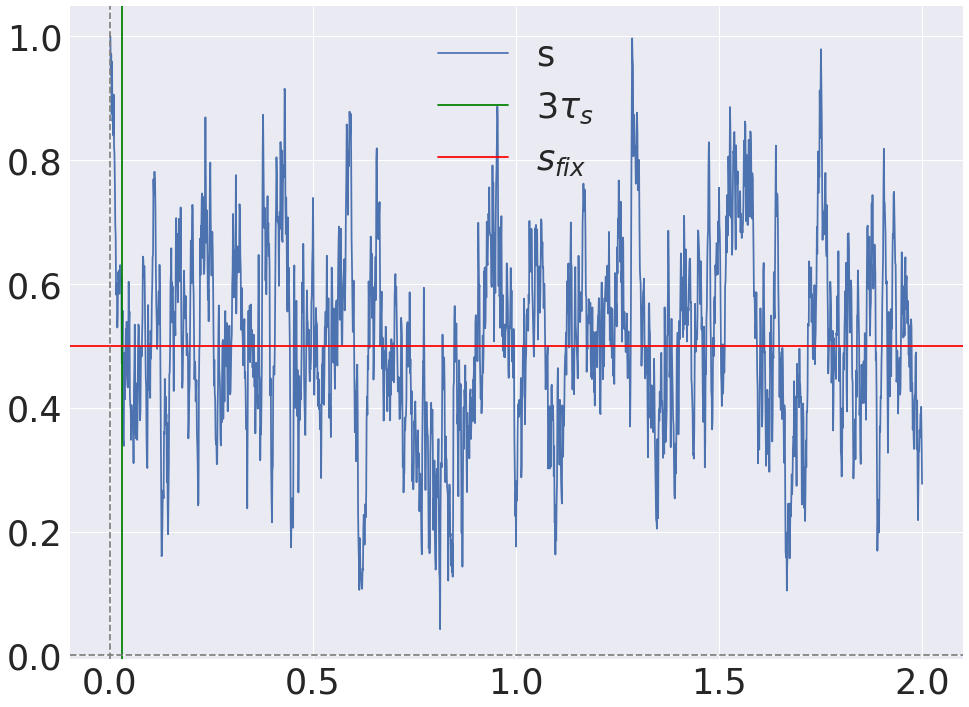

In [40]:
T = 2.0
dt = 0.001
sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T + dt, dt)
nt = time.size

tau_s = 0.010
ns = int(tau_s / dt)
s0 = 1.0
sigma = 2.0
s_fix = 0.5
s = np.zeros(nt)
s[0] = s0
noise = np.random.randn(nt)

for index in range(time.size - 1):
    s[index + 1] = s[index] + (s_fix - s[index]) * (dt / tau_s) + (sqrt_dt * sigma) * noise[index]

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(time, s, label='s')


ax.axvline(3 * tau_s, ls='-', color='green', label=r'$3 \tau_s$')
ax.axhline(s_fix, ls='-', color='red', label=r'$s_{fix}$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

In [41]:
s_relaxed = s[ns:]
var = s_relaxed.var()
var_theo = 0.5 *tau_s * sigma ** 2
print('var', var, r'theoretical variance', var_theo, 'normal variance of the noise', sigma ** 2)
print('mean', s_relaxed.mean(), 's_fix', s_fix)

var 0.0235701444607 theoretical variance 0.02 normal variance of the noise 4.0
mean 0.507348511752 s_fix 0.5


Let's run a deterministic process close to a bunch of theoretical ones

In [70]:
% time
T = 1.0
dt = 0.001
sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T + dt, dt)
nt = time.size
n_process = 500

tau_s = 0.010
ns = int(tau_s / dt)
s0 = 1.0
sigma = 1.5
s_fix = 0.5
s = np.zeros((n_process, nt))
s_dete = np.zeros(nt)
s[:, 0] = s0
s_dete[0] = s0
noise = np.random.randn(n_process, nt)

for index in range(time.size - 1):
    s[:, index + 1] = s[:, index] + (s_fix - s[:, index]) * (dt / tau_s) + (sqrt_dt * sigma) * noise[:, index]
    s_dete[index + 1] = s_dete[index] + (s_fix - s_dete[index]) * (dt / tau_s)

    
s_relaxed = s[:, ns:]
t_relaxed = time[ns:]
std = s.std(axis=0)
sigma_theo = np.sqrt(0.5 * tau_s * sigma**2)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


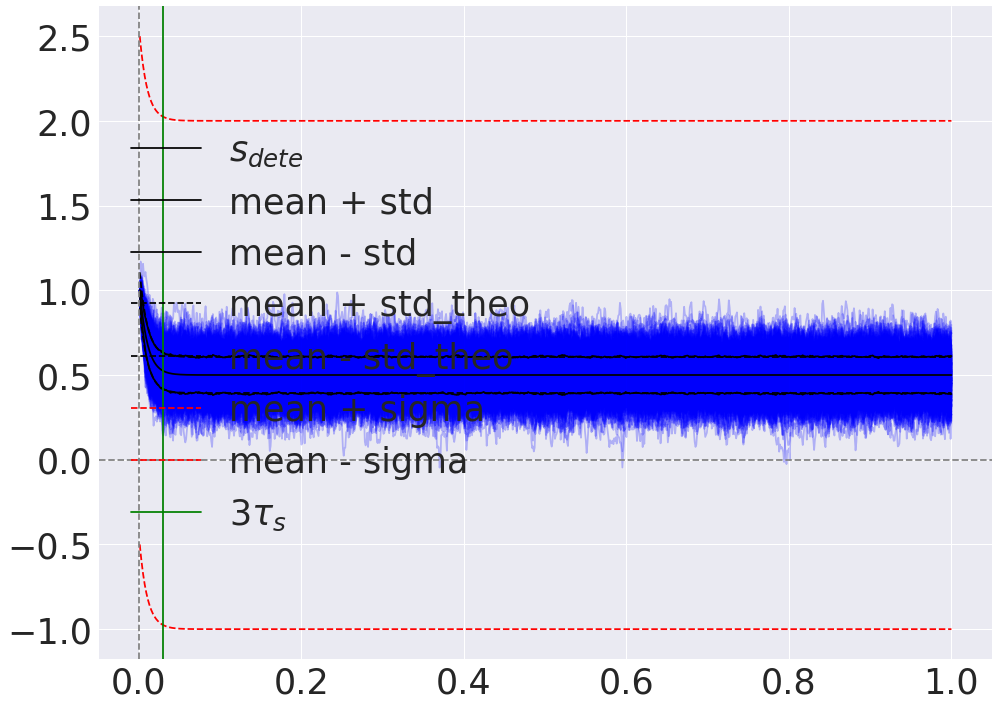

In [73]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(time, s.T, color='blue', alpha=0.25)
ax.plot(time, s_dete, label=r'$s_{dete}$', color='black', alpha=1.0)
ax.plot(time, s_dete + std, label=r'mean + std', color='black', alpha=1.0)
ax.plot(time, s_dete - std, label=r'mean - std', color='black', alpha=1.0)
ax.plot(time, s_dete + sigma_theo, ls='--', label=r'mean + std_theo', color='black', alpha=1.0)
ax.plot(time, s_dete - sigma_theo, ls='--', label=r'mean - std_theo', color='black', alpha=1.0)
ax.plot(time, s_dete + sigma, ls='--', label=r'mean + sigma', color='red', alpha=1.0)
ax.plot(time, s_dete - sigma, ls='--', label=r'mean - sigma', color='red', alpha=1.0)

ax.axvline(3 * tau_s, ls='-', color='green', label=r'$3 \tau_s$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

In [67]:
s_relaxed = s[:, ns:]
t_relaxed = time[ns:]
stationary_mean = s_relaxed.mean(axis=0)
stationary_var = s_relaxed.var(axis=0)
var_theo = 0.5 * tau_s * sigma**2

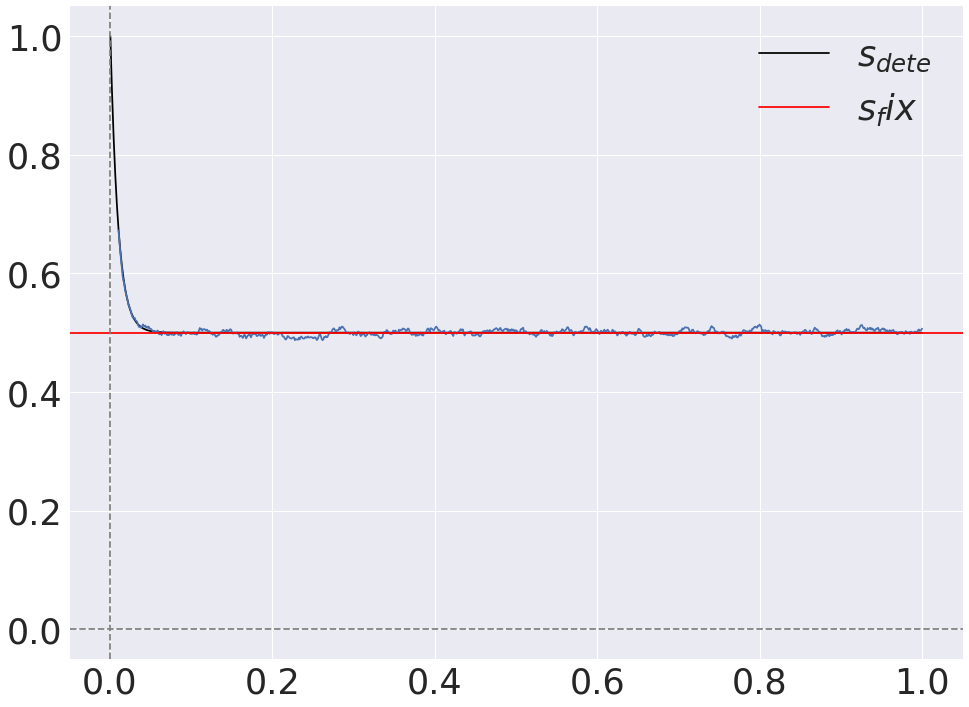

In [69]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(time, s_dete, label=r'$s_{dete}$', color='black', alpha=1.0)
ax.plot(t_relaxed, stationary_mean)
ax.axhline(s_fix, ls='-', color='red', label=r'$s_{fix}$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

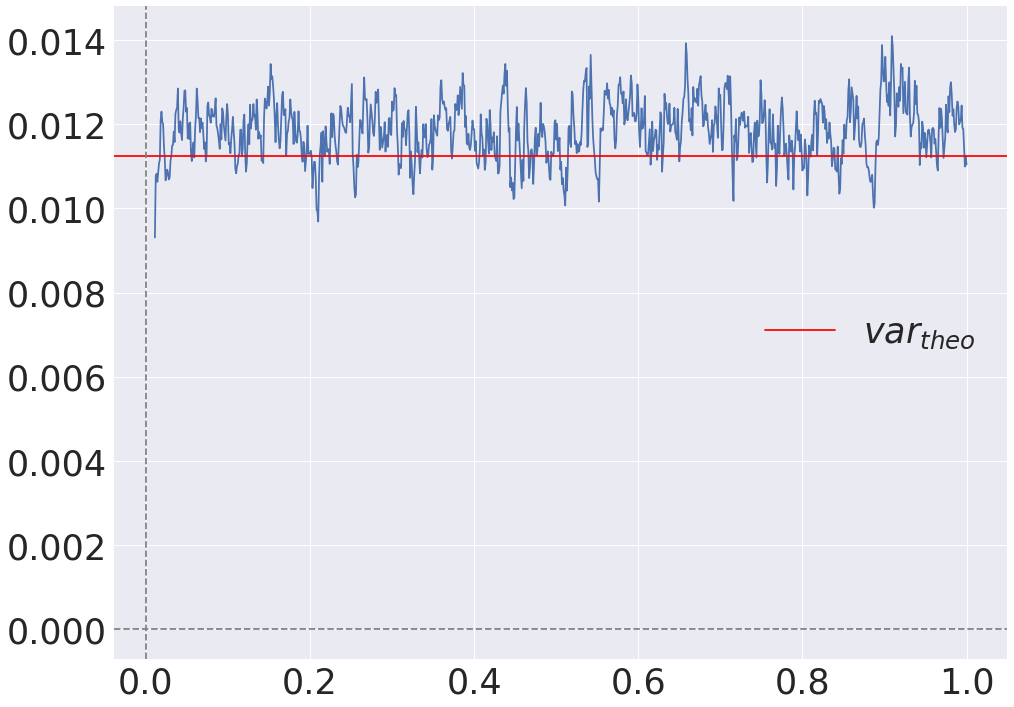

In [68]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(t_relaxed, stationary_var)
ax.axhline(var_theo, ls='-', color='red', label=r'$var_{theo}$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();


## Let's make the decaying process now in the OU (a  drifting mean)

In [117]:
% time
T = 0.150
dt = 0.00005
sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T + dt, dt)
nt = time.size
n_process = 300
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.0
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_w = 1.0
g_a = 1.0
perfect = False
steady_state = False


s0 = w_next
sigma = 0.5


T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
mu = mean_at_t(time, w_self, w_next, g_a, tau_s, tau_a, s0=s0, perfect=perfect, steady_state=steady_state)

s = np.zeros((n_process, nt))
s_det = np.zeros(nt)
s_det[0] = s0
s[:, 0] = s0
noise = (sqrt_dt * sigma) * np.random.randn(n_process, nt)
current = w_self - g_a * (1 - np.exp(-time / tau_a))

for index in range(time.size - 1):
    s[:, index + 1] = s[:, index] + (current[index] - s[:, index]) * (dt / tau_s) +  noise[:, index]
    s_det[index + 1] = s_det[index] + (current[index] - s_det[index]) * (dt / tau_s)


std = s.std(axis=0)
sigma_theo = np.sqrt(0.5 * tau_s * sigma**2)
mean = s.mean(axis=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs


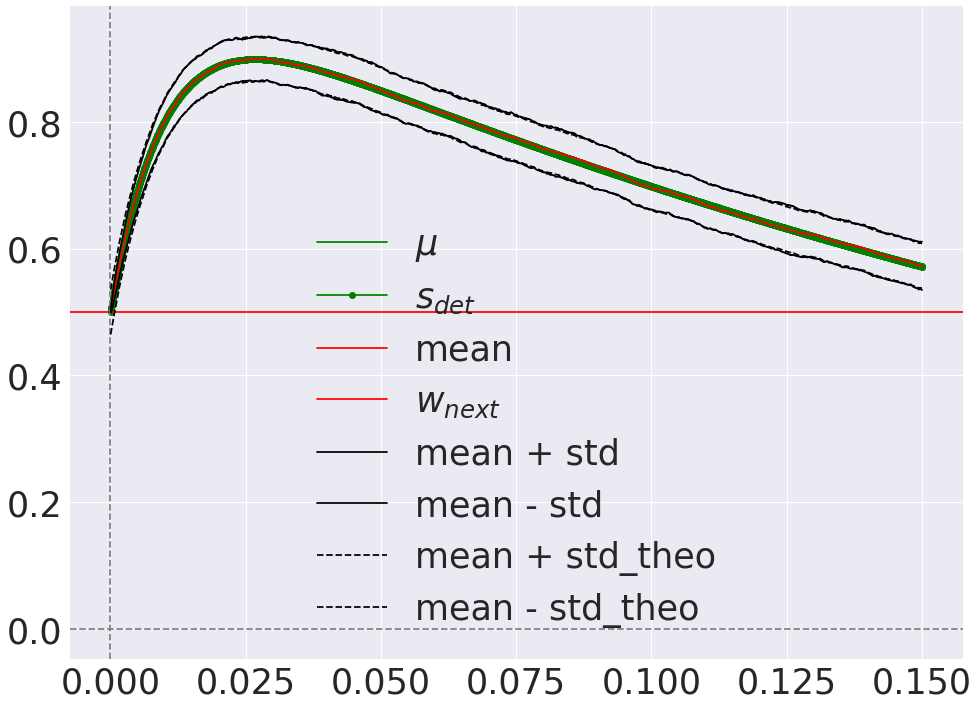

In [118]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(time, s.T, color='blue', alpha=0.25)
ax.plot(time, mu, label=r'$\mu$', color='green', alpha=1.0)
ax.plot(time, s_det, 'o-', label=r'$s_{det}$',color='green', alpha=1.0)
ax.plot(time, mean, label=r'mean', color='red', alpha=1.0)


#ax.axvline(3 * tau_s, ls='-', color='green', label=r'$3 \tau_s$')
ax.axhline(w_next, ls='-', color='red', label=r'$w_{next}$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.plot(time, mean + std, label=r'mean + std', color='black', alpha=1.0)
ax.plot(time, mean - std, label=r'mean - std', color='black', alpha=1.0)
ax.plot(time, mean + sigma_theo, ls='--', label=r'mean + std_theo', color='black', alpha=1.0)
ax.plot(time, mean - sigma_theo, ls='--', label=r'mean - std_theo', color='black', alpha=1.0)

ax.legend();

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


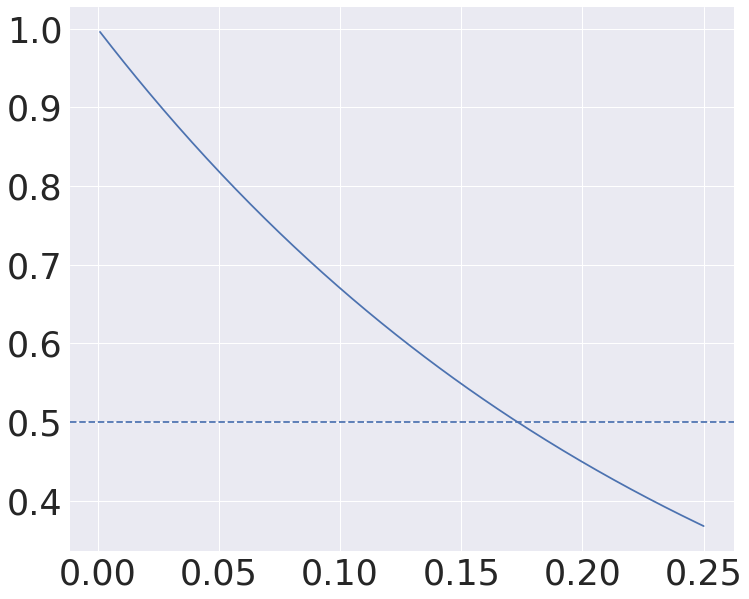

In [112]:
% time
T = 0.250
dt = 0.001
sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T + dt, dt)
nt = time.size
n_process = 300
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.4
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_w = 1.0
g_a = 1.0
perfect = False
steady_state = True
s0 = 0.5
sigma = 0.5


plt.plot(time, current)
plt.axhline(s0, ls='--')

### Let's have three trajectories

In [120]:
% time
T = 0.150
dt = 0.00005
sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T + dt, dt)
nt = time.size
n_process = 300
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.0
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_w = 1.0
g_a = 1.0
perfect = False
steady_state = False


s0 = w_next
sigma = 0.5

s1 = np.zeros((n_process, nt))
s1[:, 0] = s0
noise1 = (sqrt_dt * sigma) * np.random.randn(n_process, nt)

s2 = np.zeros((n_process, nt))
s2[:, 0] = w_rest
noise2 = (sqrt_dt * sigma) * np.random.randn(n_process, nt)

s3 = np.zeros((n_process, nt))
s3[:, 0] = -0.5
noise3 = (sqrt_dt * sigma) * np.random.randn(n_process, nt)

current = w_self - g_a * (1 - np.exp(-time / tau_a))

for index in range(time.size - 1):
    s1[:, index + 1] = s1[:, index] + (current[index] - s1[:, index]) * (dt / tau_s) +  noise1[:, index]
    s2[:, index + 1] = s2[:, index] + (w_next - s2[:, index]) * (dt / tau_s) +  noise2[:, index] 
    s3[:, index + 1] = s3[:, index] + (w_rest - s3[:, index]) * (dt / tau_s) +  noise3[:, index]


sigma_theo = np.sqrt(0.5 * tau_s * sigma**2)
mean1 = s1.mean(axis=0)
std1 = s1.std(axis=0)

mean2 = s2.mean(axis=0)
std2 = s2.std(axis=0)

mean3 = s3.mean(axis=0)
std3 = s3.std(axis=0)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


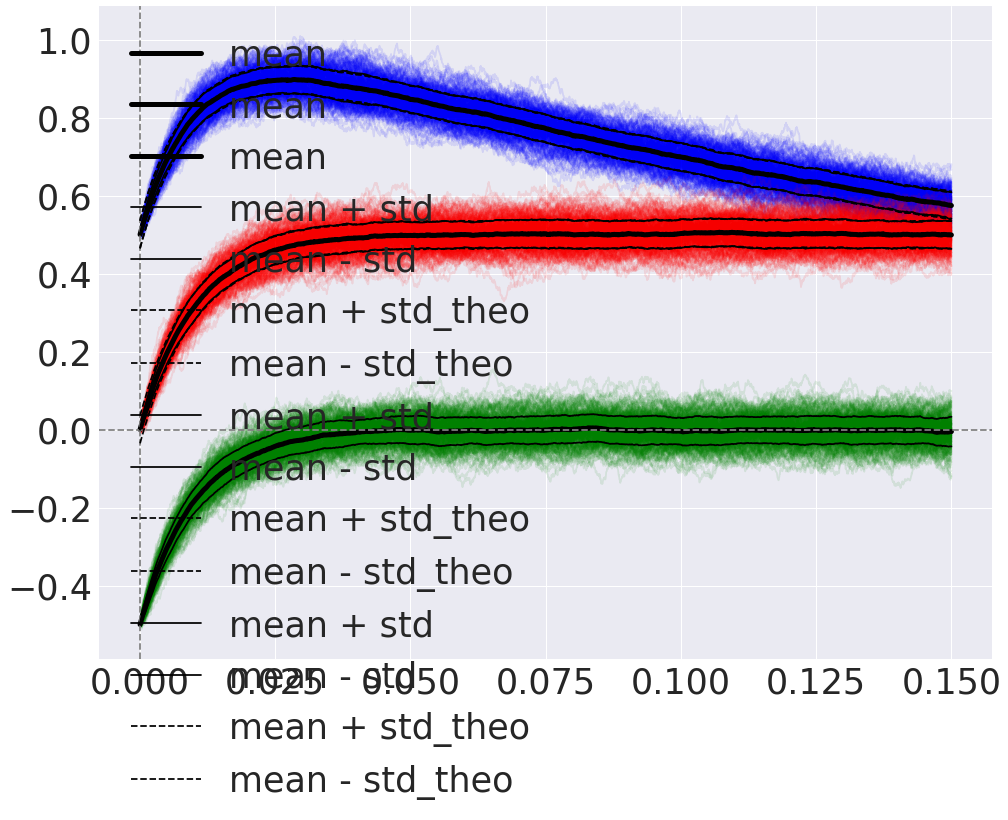

In [123]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

alpha = 0.1
ax.plot(time, s1.T, color='blue', alpha=alpha)
ax.plot(time, s2.T, color='red', alpha=alpha)
ax.plot(time, s3.T, color='green', alpha=alpha)

ax.plot(time, mean1, lw=5, label=r'mean', color='black', alpha=1.0)
ax.plot(time, mean2, lw=5, label=r'mean', color='black', alpha=1.0)
ax.plot(time, mean3, lw=5, label=r'mean', color='black', alpha=1.0)

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.plot(time, mean1 + std1, label=r'mean + std', color='black', alpha=1.0)
ax.plot(time, mean1 - std1, label=r'mean - std', color='black', alpha=1.0)
ax.plot(time, mean1 + sigma_theo, ls='--', label=r'mean + std_theo', color='black', alpha=1.0)
ax.plot(time, mean1 - sigma_theo, ls='--', label=r'mean - std_theo', color='black', alpha=1.0)

ax.plot(time, mean2 + std2, label=r'mean + std', color='black', alpha=1.0)
ax.plot(time, mean2 - std2, label=r'mean - std', color='black', alpha=1.0)
ax.plot(time, mean2 + sigma_theo, ls='--', label=r'mean + std_theo', color='black', alpha=1.0)
ax.plot(time, mean2 - sigma_theo, ls='--', label=r'mean - std_theo', color='black', alpha=1.0)

ax.plot(time, mean3 + std3, label=r'mean + std', color='black', alpha=1.0)
ax.plot(time, mean3 - std3, label=r'mean - std', color='black', alpha=1.0)
ax.plot(time, mean1 + sigma_theo, ls='--', label=r'mean + std_theo', color='black', alpha=1.0)
ax.plot(time, mean1 - sigma_theo, ls='--', label=r'mean - std_theo', color='black', alpha=1.0)

ax.legend();

## One trjectory outcome

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs


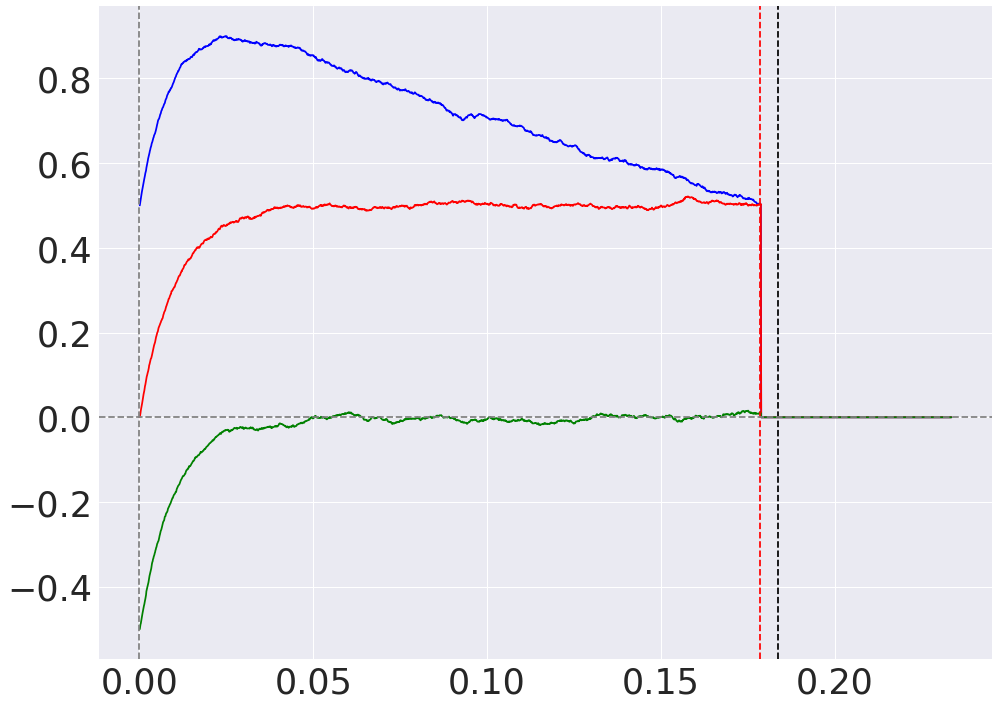

In [169]:
% time
T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T = T_per + 0.050
dt = 0.0001
sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T + dt, dt)
nt = time.size
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.0
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_w = 1.0
g_a = 1.0

s0 = w_next
sigma = 0.1

s1 = np.zeros(nt)
s1[0] = s0
noise1 = (sqrt_dt * sigma) * np.random.randn(nt)

s2 = np.zeros(nt)
s2[0] = w_rest
noise2 = (sqrt_dt * sigma) * np.random.randn(nt)

s3 = np.zeros(nt)
s3[0] = -0.5
noise3 = (sqrt_dt * sigma) * np.random.randn(nt)
    
current = w_self - g_a * (1 - np.exp(-time / tau_a))
for index in range(time.size - 1):
    s1_ = s1[index] + (current[index] - s1[index]) * (dt / tau_s) +  noise1[index]
    s2_ = s2[index] + (w_next - s2[index]) * (dt / tau_s) +  noise2[index] 
    s3_ = s3[index] + (w_rest - s3[index]) * (dt / tau_s) +  noise3[index]
    
    s1[index + 1] = s1_
    s2[index + 1] = s2_
    s3[index + 1] = s3_
    if s2_ > s1_ and s2_ > s3_:
        winner = 2
        T_win = index
        break 
    if s3_ > s1_ and s3_ > s1_:
        winner = 3
        T_win = index
        
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

alpha = 1.0
ax.plot(time, s1.T, color='blue', alpha=alpha)
ax.plot(time, s2.T, color='red', alpha=alpha)
ax.plot(time, s3.T, color='green', alpha=alpha)

ax.axvline(T_win * dt, ls='--', color='red')
ax.axvline(T_per , ls='--', color='black')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

In [320]:
def run_simulation(sigma, w_self, w_next, w_rest, tau_s, tau_a, g_a,  dt, T_total):
    sqrt_dt = np.sqrt(dt)
    time = np.arange(dt, T_total + dt, dt)
    nt = time.size
    
    s1 = np.zeros(nt)
    s1[0] = w_next
    noise1 = (sqrt_dt * sigma) * np.random.randn(nt)

    s2 = np.zeros(nt)
    s2[0] = w_rest
    noise2 = (sqrt_dt * sigma) * np.random.randn(nt)

    s3 = np.zeros(nt)
    s3[0] = w_rest - (w_next - w_rest)
    noise3 = (sqrt_dt * sigma) * np.random.randn(nt)


    current = w_self - g_a * (1 - np.exp(-time / tau_a))
    winner = 1.0
    T_win = 1000.0
    for index in range(time.size - 1):
        s1_ = s1[index] + (current[index] - s1[index]) * (dt / tau_s) +  noise1[index]
        s2_ = s2[index] + (w_next - s2[index]) * (dt / tau_s) +  noise2[index] 
        s3_ = s3[index] + (w_rest - s3[index]) * (dt / tau_s) +  noise3[index]
    
        s1[index + 1] = s1_
        s2[index + 1] = s2_
        s3[index + 1] = s3_
        if s2_ > s1_ and s2_ > s3_:
            winner = 2
            T_win = index * dt
            break 
        if s3_ > s1_ and s3_ > s2_:
            winner = 3
            T_win = index * dt
            break
        
    return winner, T_win 

In [322]:
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.0
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_a = 1.0

T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)

n_process = 300
sigma = 0.5
T = T_per + 0.050
dt = 0.0005

winner, T_win = run_simulation(sigma, w_self, w_next, w_rest, tau_s, tau_a, g_a,  dt, T)
print(T_per, T_win)
print(winner)

0.18349229377 0.1395
2


Let's collect statistics for noise, the time to change should increase and myabe the failures (3) should increase

In [323]:
%%time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.25
w_rest = 0.0
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_a = 1.0

T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)

n_sim = 500
sigma = 0.5
T = T_per + 0.050
dt = 0.0005

winner = np.zeros(n_sim)
T_per_vector = np.zeros(n_sim)

for i in range(n_sim):
    win, T_win = run_simulation(sigma, w_self, w_next, w_rest, tau_s, tau_a, g_a,  dt, T)
    winner[i] = win
    T_per_vector[i] = T_win
    
print(np.mean(T_per_vector) )
print(T_per)

0.305167
0.35677908891
CPU times: user 716 ms, sys: 0 ns, total: 716 ms
Wall time: 719 ms


In [324]:
success = np.mean(winner == 2)
failure = np.mean(winner == 3)
print(success)
print(failure)

1.0
0.0


In [338]:
%%time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.25
w_diff = w_self - w_next
w_rob = w_self - w_rest
g_a = 1.0

num = 50
n_sim = 500
sigma_vector = np.linspace(0.1, 10, num=num)
winners = np.zeros((n_sim, num))
T_per_vector = np.zeros((n_sim, num))

T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T = T_per + 0.050
dt = 0.0005
for sigma_index, sigma in enumerate(sigma_vector):
    for i in range(n_sim):
        win, T_win = run_simulation(sigma, w_self, w_next, w_rest, tau_s, tau_a, g_a,  dt, T)
        winners[i, sigma_index] = win
        T_per_vector[i, sigma_index] = T_win

CPU times: user 6.67 s, sys: 0 ns, total: 6.67 s
Wall time: 6.67 s


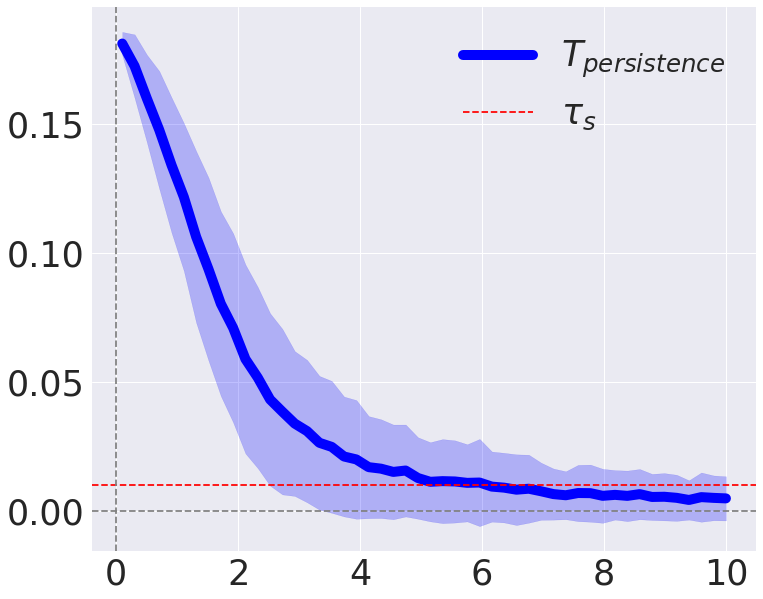

In [340]:
T_per_mean = np.mean(T_per_vector, axis=0)
std = np.std(T_per_vector, axis=0)

lw = 10
alpha = 0.25

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sigma_vector, T_per_mean, lw=lw, color='blue', label= r'$T_{persistence}$')
ax.fill_between(sigma_vector, T_per_mean - std, T_per_mean + std,
                color='blue', alpha=alpha)

ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

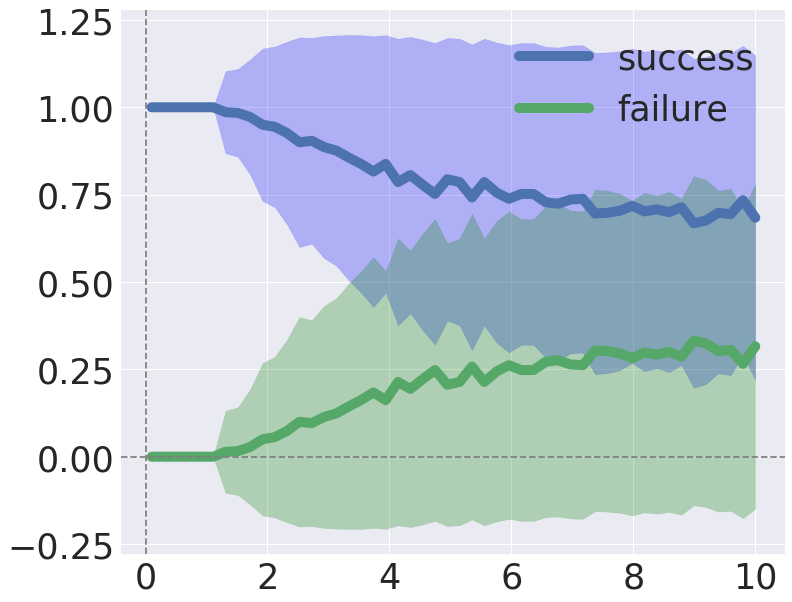

In [326]:
V

#### Simulation continuated

In [335]:
%% time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.0
w_rest2 = -0.5
w_back = -2.0

g_w = 1.0
g_a = 2.0

T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T = 2 * T_per + tau_s
dt = 0.0001
sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T + dt, dt)
nt = time.size

s0 = w_next
sigma = 1.0

s1 = np.zeros(nt)
s1[0] = s0
noise1 = (sqrt_dt * sigma) * np.random.randn(nt)

s2 = np.zeros(nt)
s2[0] = w_rest
noise2 = (sqrt_dt * sigma) * np.random.randn(nt)

s3 = np.zeros(nt)
s3[0] = w_rest2
noise3 = (sqrt_dt * sigma) * np.random.randn(nt)

s4 = np.zeros(nt)
s4[0] = -1.0
noise4 = (sqrt_dt * sigma) * np.random.randn(nt)
    
current = w_self - g_a * (1 - np.exp(-time / tau_a))

winner1 = 1
index = 0
while (winner1 == 1):
    s1_ = s1[index] + (current[index] - s1[index]) * (dt / tau_s) +  noise1[index]
    s2_ = s2[index] + (w_next - s2[index]) * (dt / tau_s) +  noise2[index] 
    s3_ = s3[index] + (w_rest - s3[index]) * (dt / tau_s) +  noise3[index]
    s4_ = s4[index] + (w_rest2 - s4[index]) * (dt / tau_s) +  noise4[index]

    s1[index + 1] = s1_
    s2[index + 1] = s2_
    s3[index + 1] = s3_
    s4[index + 1] = s4_
    
    index += 1

    if s2_ > s1_ and s2_ > s3_ and s2_ > s4_:
        winner1 = 2
        T_win1 = index * dt
        break 
    if s3_ > s1_ and s3_ > s2_ and s3_ > s4_:
        winner1 = 3
        T_win1 = index * dt
        break 
    if s4_ > s1_ and s4_ > s2_ and s4_ > s3_:
        winner1 = 4
        T_win1 = index * dt
        break 

winner2 = winner1
factor = np.exp(T_win1 / tau_a)
current2 = w_self - g_a * (1  - np.exp(-time / tau_a) * factor)
while(winner2 == winner1):
    s1_ = s1[index] + (w_back - s1[index]) * (dt / tau_s) +  noise1[index]
    s2_ = s2[index] + (current2[index] - s2[index]) * (dt / tau_s) +  noise2[index] 
    s3_ = s3[index] + (w_next - s3[index]) * (dt / tau_s) +  noise3[index]
    s4_ = s4[index] + (w_rest - s4[index]) * (dt / tau_s) +  noise4[index]

    s1[index + 1] = s1_
    s2[index + 1] = s2_
    s3[index + 1] = s3_
    s4[index + 1] = s4_
    
    index += 1

    if s1_ > s2_ and s1_ > s3_ and s1_ > s4_:
        winner2 = 1
        T_win2 = index * dt
        break 
    if s3_ > s1_ and s3_ > s2_ and s3_ > s4_:
        winner2 = 3
        T_win2 = index * dt
        break 
    if s4_ > s1_ and s4_ > s2_ and s4_ > s3_:
        winner2 = 4
        T_win2 = index * dt
        break 

print(winner1, T_win1)
print(winner2, T_win2)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.53 µs
2 0.0654
3 0.1359


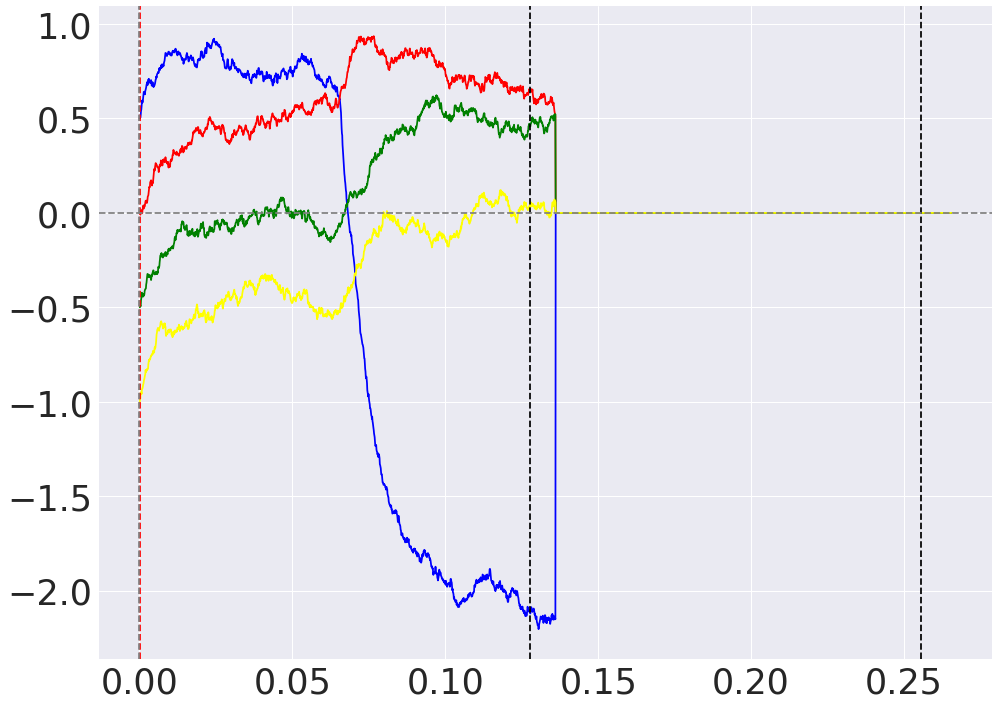

In [336]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

alpha = 1.0
ax.plot(time, s1.T, color='blue', alpha=alpha)
ax.plot(time, s2.T, color='red', alpha=alpha)
ax.plot(time, s3.T, color='green', alpha=alpha)
ax.plot(time, s4.T, color='yellow', alpha=alpha)


ax.axvline(T_win * dt, ls='--', color='red')
ax.axvline(T_per , ls='--', color='black')
ax.axvline(2 * T_per , ls='--', color='black')



ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
# ax.set_xlim([0.020, 0.040])

In [404]:
def simulation_consecutive(sigma, w_self, w_next, w_rest, w_rest2, w_back, tau_s, tau_a, g_a,  dt, T_total):

    sqrt_dt = np.sqrt(dt)
    time = np.arange(dt, T_total + dt, dt)
    nt = time.size

    s0 = w_next

    s1 = np.zeros(nt)
    s1[0] = s0
    noise1 = (sqrt_dt * sigma) * np.random.randn(nt)

    s2 = np.zeros(nt)
    s2[0] = w_rest
    noise2 = (sqrt_dt * sigma) * np.random.randn(nt)

    s3 = np.zeros(nt)
    s3[0] = w_rest2
    noise3 = (sqrt_dt * sigma) * np.random.randn(nt)

    s4 = np.zeros(nt)
    s4[0] = -1.0
    noise4 = (sqrt_dt * sigma) * np.random.randn(nt)

    current = w_self - g_a * (1 - np.exp(-time / tau_a))

    winner1 = 1
    index = 0
    while (winner1 == 1 and index*dt < T_total):
        s1_ = s1[index] + (current[index] - s1[index]) * (dt / tau_s) +  noise1[index]
        s2_ = s2[index] + (w_next - s2[index]) * (dt / tau_s) +  noise2[index] 
        s3_ = s3[index] + (w_rest - s3[index]) * (dt / tau_s) +  noise3[index]
        s4_ = s4[index] + (w_rest2 - s4[index]) * (dt / tau_s) +  noise4[index]

        s1[index + 1] = s1_
        s2[index + 1] = s2_
        s3[index + 1] = s3_
        s4[index + 1] = s4_

        index += 1

        if s2_ > s1_ and s2_ > s3_ and s2_ > s4_:
            winner1 = 2
            T_win1 = index * dt
            break 
        if s3_ > s1_ and s3_ > s2_ and s3_ > s4_:
            winner1 = 3
            T_win1 = index * dt
            break 
        if s4_ > s1_ and s4_ > s2_ and s4_ > s3_:
            winner1 = 4
            T_win1 = index * dt
            break 

    winner2 = winner1
    factor = np.exp(T_win1 / tau_a)
    current2 = w_self - g_a * (1  - np.exp(-time / tau_a) * factor)
    
    if winner1 != 2:   # Not success on the first 
        winner2 == np.nan
        T_win2 = np.nan
    else:
        while(index*dt < T_total):
            s1_ = s1[index] + (w_back - s1[index]) * (dt / tau_s) +  noise1[index]
            s2_ = s2[index] + (current2[index] - s2[index]) * (dt / tau_s) +  noise2[index] 
            s3_ = s3[index] + (w_next - s3[index]) * (dt / tau_s) +  noise3[index]
            s4_ = s4[index] + (w_rest - s4[index]) * (dt / tau_s) +  noise4[index]

            s1[index + 1] = s1_
            s2[index + 1] = s2_
            s3[index + 1] = s3_
            s4[index + 1] = s4_

            index += 1

            if s1_ > s2_ and s1_ > s3_ and s1_ > s4_:
                winner2 = 1
                T_win2 = index * dt - T_win1
                break 
            if s3_ > s1_ and s3_ > s2_ and s3_ > s4_:
                winner2 = 3
                T_win2 = index * dt - T_win1
                break 
            if s4_ > s1_ and s4_ > s2_ and s4_ > s3_:
                winner2 = 4
                T_win2 = index * dt - T_win1
                break 

    return T_win1, T_win2, winner1, winner2

In [405]:
%%time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.0
w_rest2 = -0.5
w_back = -3.0

g_w = 1.0
g_a = 2.0

sigma = 0.0

w_diff = w_self - w_rest
dt = 0.0001
T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T_total = 2.5 * T_per

T_win1, T_win2, winner1, winner2 = simulation_consecutive(sigma, w_self, w_next, w_rest, w_rest2, w_back,
                                                          tau_s, tau_a, g_a,  dt, T_total)

print(T_win1, T_win2)
print(winner1, winner2)

0.0821 0.0821
2 3
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.24 ms


In [449]:
%%time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_next = 0.5
w_rest = 0.25
w_back = -10.0
g_a = 1.0

num = 100
n_sim = 500
sigma_vector = np.linspace(0.1, 10, num=num)
winners1 = np.zeros((n_sim, num))
winners2 = np.zeros((n_sim, num))
T_per_vector1 = np.zeros((n_sim, num))
T_per_vector2 = np.zeros((n_sim, num))

T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T_total = 2.5 * T_per
dt = 0.0005
for sigma_index, sigma in enumerate(sigma_vector):
    for i in range(n_sim):
        aux = simulation_consecutive(sigma, w_self, w_next, w_rest, w_rest2, w_back,
                                     tau_s, tau_a, g_a,  dt, T_total)
        T_win1, T_win2, winner1, winner2  = aux
        winners1[i, sigma_index] = winner1
        T_per_vector1[i, sigma_index] = T_win1
        winners2[i, sigma_index] = winner2
        T_per_vector2[i, sigma_index] = T_win2

CPU times: user 36.9 s, sys: 80 ms, total: 37 s
Wall time: 37.2 s


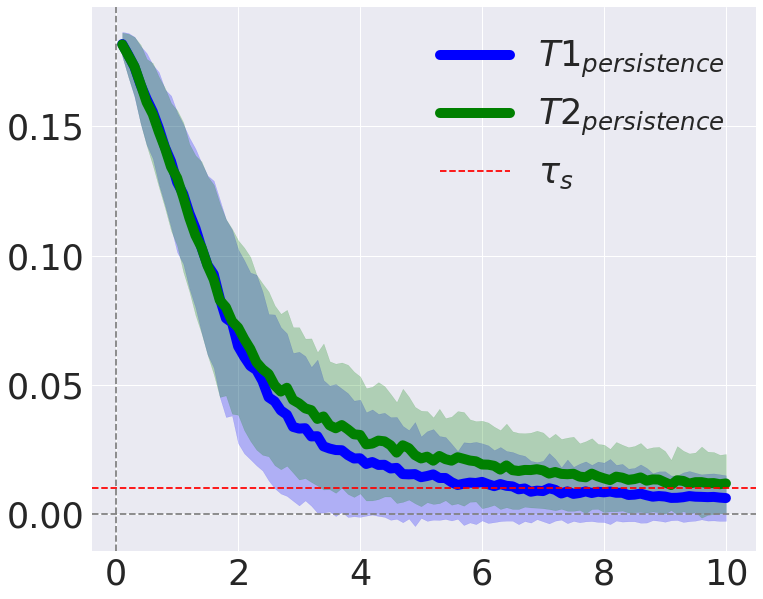

In [450]:
T_per_mean1 = np.mean(T_per_vector1, axis=0)
T_per_mean2 = np.nanmean(T_per_vector2, axis=0)

std1 = np.std(T_per_vector1, axis=0)
std2 = np.nanstd(T_per_vector2, axis=0)


lw = 10
alpha = 0.25

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sigma_vector, T_per_mean1, lw=lw, color='blue', label= r'$T1_{persistence}$')
ax.fill_between(sigma_vector, T_per_mean1 - std1, T_per_mean1 + std1,
                color='blue', alpha=alpha)

ax.plot(sigma_vector, T_per_mean2, lw=lw, color='green', label= r'$T2_{persistence}$')
ax.fill_between(sigma_vector, T_per_mean2 - std2, T_per_mean2 + std2,
                color='green', alpha=alpha)

ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

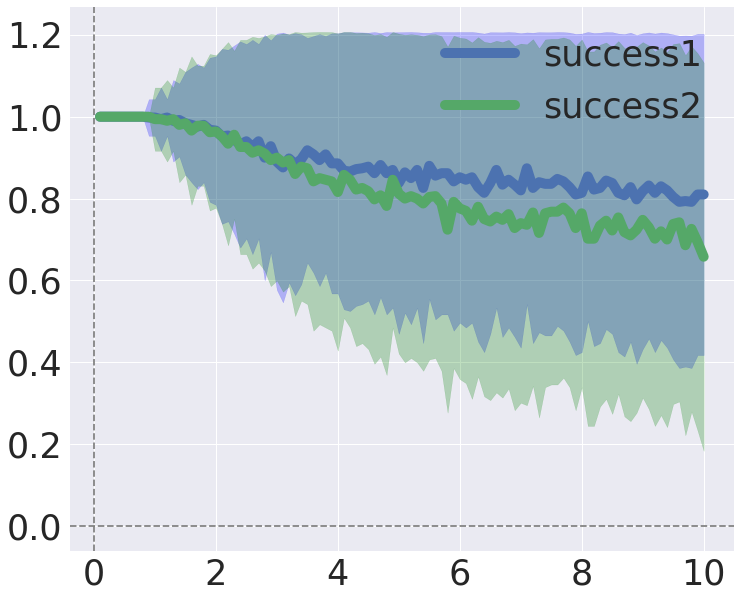

In [451]:
lw = 10
alpha = 0.25
success1 = np.mean(winners1 == 2, axis=0)
std_success1 = np.std(winners1 == 2, axis=0)
failure1 = np.mean(winners1 == 3, axis=0)
std_failure1 = np.std(winners1 == 3, axis=0)

n_survival = np.sum(winners1 == 2, axis=0)

success2 = np.nanmean(winners2 == 3, axis=0)
std_success2 = np.nanstd(winners2 == 3, axis=0)
failure2 = np.nanmean(winners2 == 4, axis=0)
std_failure2 = np.nanstd(winners2 == 4, axis=0)

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sigma_vector, success1, lw=lw, label='success1')
ax.fill_between(sigma_vector, success1 - std_success1, success1 + std_success1,
                color='blue', alpha=alpha)

ax.plot(sigma_vector, success2, lw=lw, label='success2')
ax.fill_between(sigma_vector, success2 - std_success2, success2 + std_success2,
                color='green', alpha=alpha)


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

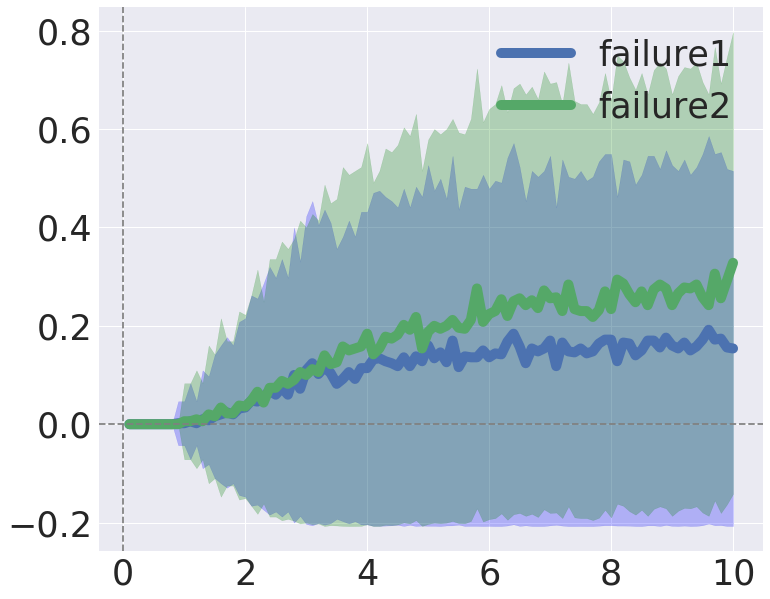

In [452]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sigma_vector, failure1, lw=lw, label='failure1')
ax.fill_between(sigma_vector, failure1 - std_failure1, failure1 + std_failure1,
                color='blue', alpha=alpha)

ax.plot(sigma_vector, failure2, lw=lw, label='failure2')
ax.fill_between(sigma_vector, failure2 - std_failure2, failure2 + std_failure2,
                color='green', alpha=alpha)


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

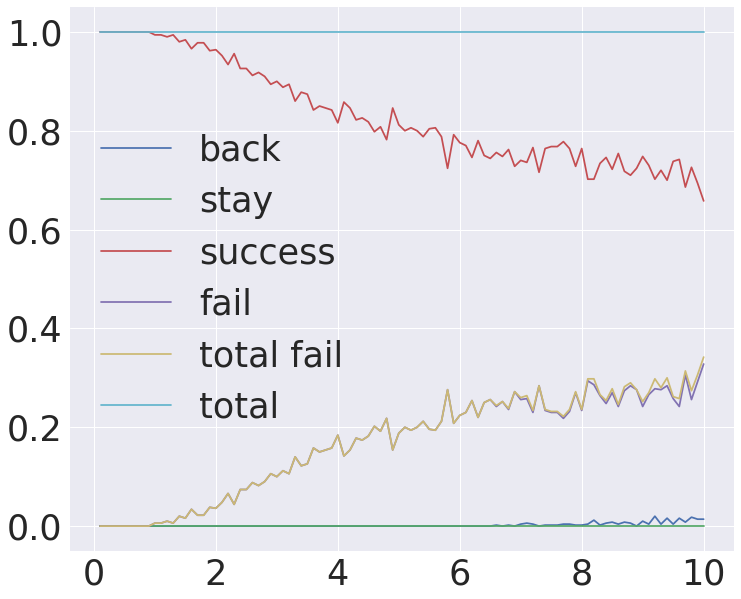

In [453]:
total = np.nanmean(winners2 == 4, axis=0) + np.nanmean(winners2 == 1, axis=0)  + np.nanmean(winners2 == 3, axis=0)

plt.plot(sigma_vector, np.nanmean(winners2 == 1, axis=0), label='back')
plt.plot(sigma_vector, np.nanmean(winners2 == 2, axis=0), label='stay')
plt.plot(sigma_vector, np.nanmean(winners2 == 3, axis=0), label='success')
plt.plot(sigma_vector, np.nanmean(winners2 == 4, axis=0), label='fail')
plt.plot(sigma_vector, np.nanmean(winners2 == 4, axis=0) + np.nanmean(winners2 == 1, axis=0), label='total fail')
plt.plot(sigma_vector, total, label='total')


plt.legend()

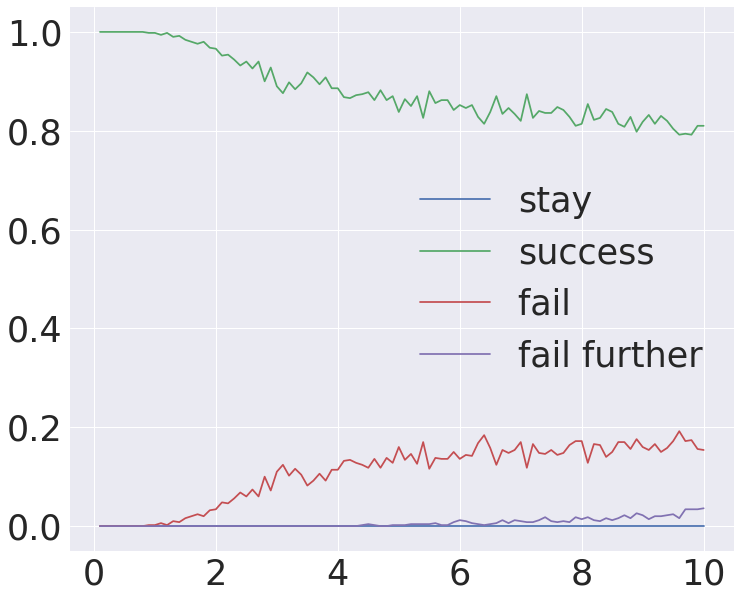

In [454]:
plt.plot(sigma_vector, np.nanmean(winners1 == 1, axis=0), label='stay')
plt.plot(sigma_vector, np.nanmean(winners1 == 2, axis=0), label='success')
plt.plot(sigma_vector, np.nanmean(winners1 == 3, axis=0), label='fail ')
plt.plot(sigma_vector, np.nanmean(winners1 == 4, axis=0), label='fail further')

plt.legend()

In [514]:
%%time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
alpha  = 0.5
w_back = -3.0

g_w = 1.0
g_a = 2.0

sigma = 2.1

w_diff = w_self - alpha
dt = 0.0001
T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T_total = 3.5 * T_per

sqrt_dt = np.sqrt(dt)
time = np.arange(dt, T_total + dt, dt)
nt = time.size

s1 = np.zeros(nt)
s1[0] = w_self - alpha
noise1 = (sqrt_dt * sigma) * np.random.randn(nt)

s2 = np.zeros(nt)
s2[0] = w_self - 2 * alpha
noise2 = (sqrt_dt * sigma) * np.random.randn(nt)

s3 = np.zeros(nt)
s3[0] = w_self - 2 * alpha
noise3 = (sqrt_dt * sigma) * np.random.randn(nt)

s4 = np.zeros(nt)
s4[0] = w_self - 3 * alpha
noise4 = (sqrt_dt * sigma) * np.random.randn(nt)

s5 = np.zeros(nt)
s5[0] = w_self - 4 * alpha
noise5 = (sqrt_dt * sigma) * np.random.randn(nt)

current = w_self - g_a * (1 - np.exp(-time / tau_a))

winner1 = 1
index = 0
while (winner1 == 1 and index*dt < T_total):
    s1_ = s1[index] + (current[index] - s1[index]) * (dt / tau_s) +  noise1[index]
    s2_ = s2[index] + (w_self - alpha - s2[index]) * (dt / tau_s) +  noise2[index] 
    s3_ = s3[index] + (w_self - 2*alpha - s3[index]) * (dt / tau_s) +  noise3[index]
    s4_ = s4[index] + (w_self - 3*alpha - s4[index]) * (dt / tau_s) +  noise4[index]
    s5_ = s5[index] + (w_self - 4*alpha - s5[index]) * (dt / tau_s) +  noise5[index]

    s1[index + 1] = s1_
    s2[index + 1] = s2_
    s3[index + 1] = s3_
    s4[index + 1] = s4_
    s5[index + 1] = s5_

    index += 1

    if s1_ >= s1_ and s1_ >= s2_ and s1_ >= s3_ and s1_ >= s4_ and s1_ >= s5_:
        continue
    if s2_ >= s1_ and s2_ >= s2_ and s2_ >= s3_ and s2_ >= s4_ and s2_ >= s5_:
        winner1 = 2
        T_win1 = index * dt
        break 
    if s3_ >= s1_ and s3_ >= s2_ and s3_ >= s3_ and s3_ >= s4_ and s3_ >= s5_:
        winner1 = 3
        T_win1 = index * dt
        break 
    if s4_ >= s1_ and s4_ >= s2_ and s4_ >= s3_ and s4_ >= s4_ and s4_ >= s5_:
        winner1 = 4
        T_win1 = index * dt
        break 
    if s5_ >= s1_ and s5_ >= s2_ and s5_ >= s3_ and s5_ >= s4_ and s5_ >= s5_:
        winner1 = 5
        T_win1 = index * dt
        break 

winner2 = winner1
factor = np.exp(T_win1 / tau_a)
current2 = w_self - g_a * (1  - np.exp(-time / tau_a) * factor)

if winner1 != 2:   # Not success on the first 
    winner2 == np.nan
    T_win2 = np.nan
else:
    while(winner2 == 2 and index*dt < T_total):
        s1_ = s1[index] + (w_back - s1[index]) * (dt / tau_s) +  noise1[index]
        s2_ = s2[index] + (current2[index] - s2[index]) * (dt / tau_s) +  noise2[index] 
        s3_ = s3[index] + (w_self - alpha - s3[index]) * (dt / tau_s) +  noise3[index]
        s4_ = s4[index] + (w_self - 2*alpha - s4[index]) * (dt / tau_s) +  noise4[index]
        s5_ = s5[index] + (w_self - 3*alpha - s5[index]) * (dt / tau_s) +  noise5[index]


        s1[index + 1] = s1_
        s2[index + 1] = s2_
        s3[index + 1] = s3_
        s4[index + 1] = s4_
        s5[index + 1] = s5_

        index += 1


        if s1_ >= s1_ and s1_ >= s2_ and s1_ >= s3_ and s1_ >= s4_ and s1_ >= s5_:
            winner2 = 1
            T_win2 = index * dt 
        if s2_ >= s1_ and s2_ >= s2_ and s2_ >= s3_ and s2_ >= s4_ and s2_ >= s5_:
            continue
        if s3_ >= s1_ and s3_ >= s2_ and s3_ >= s3_ and s3_ >= s4_ and s3_ >= s5_:
            winner2 = 3
            T_win2 = index * dt
            break 
        if s4_ >= s1_ and s4_ >= s2_ and s4_ >= s3_ and s4_ >= s4_ and s4_ >= s5_:
            winner2 = 4
            T_win2 = index * dt
            break 
        if s5_ >= s1_ and s5_ >= s2_ and s5_ >= s3_ and s5_ >= s4_ and s5_ >= s5_:
            winner2 = 5
            T_win2 = index * dt
            break 

winner3 = winner2
factor = np.exp(T_win2 / tau_a)
current3 = w_self - g_a * (1  - np.exp(-time / tau_a) * factor)

if winner2 != 3:   # Not success on the first 
    winner3 == np.nan
    T_win3 = np.nan
else:
    while(index*dt < T_total):
        s1_ = s1[index] + (w_back + alpha - s1[index]) * (dt / tau_s) +  noise1[index]
        s2_ = s2[index] + (w_back - s2[index]) * (dt / tau_s) +  noise2[index] 
        s3_ = s3[index] + (current3[index] - s3[index]) * (dt / tau_s) +  noise3[index]
        s4_ = s4[index] + (w_self - alpha - s4[index]) * (dt / tau_s) +  noise4[index]
        s5_ = s5[index] + (w_self - 2*alpha - s5[index]) * (dt / tau_s) +  noise5[index]


        s1[index + 1] = s1_
        s2[index + 1] = s2_
        s3[index + 1] = s3_
        s4[index + 1] = s4_
        s5[index + 1] = s5_

        index += 1


        if s1_ >= s1_ and s1_ >= s2_ and s1_ >= s3_ and s1_ >= s4_ and s1_ >= s5_:
            winner3 = 1
            T_win3 = index * dt
        if s2_ >= s1_ and s2_ >= s2_ and s2_ >= s3_ and s2_ >= s4_ and s2_ >= s5_:
            winner3 = 2
            T_win3 = index * dt
        if s3_ >= s1_ and s3_ >= s2_ and s3_ >= s3_ and s3_ >= s4_ and s3_ >= s5_:
            continue
        if s4_ >= s1_ and s4_ >= s2_ and s4_ >= s3_ and s4_ >= s4_ and s4_ >= s5_:
            winner3 = 4
            T_win3 = index * dt
            break 
        if s5_ >= s1_ and s5_ >= s2_ and s5_ >= s3_ and s5_ >= s4_ and s5_ >= s5_:
            winner3 = 5
            T_win3 = index * dt
            break 
                

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 6.71 ms


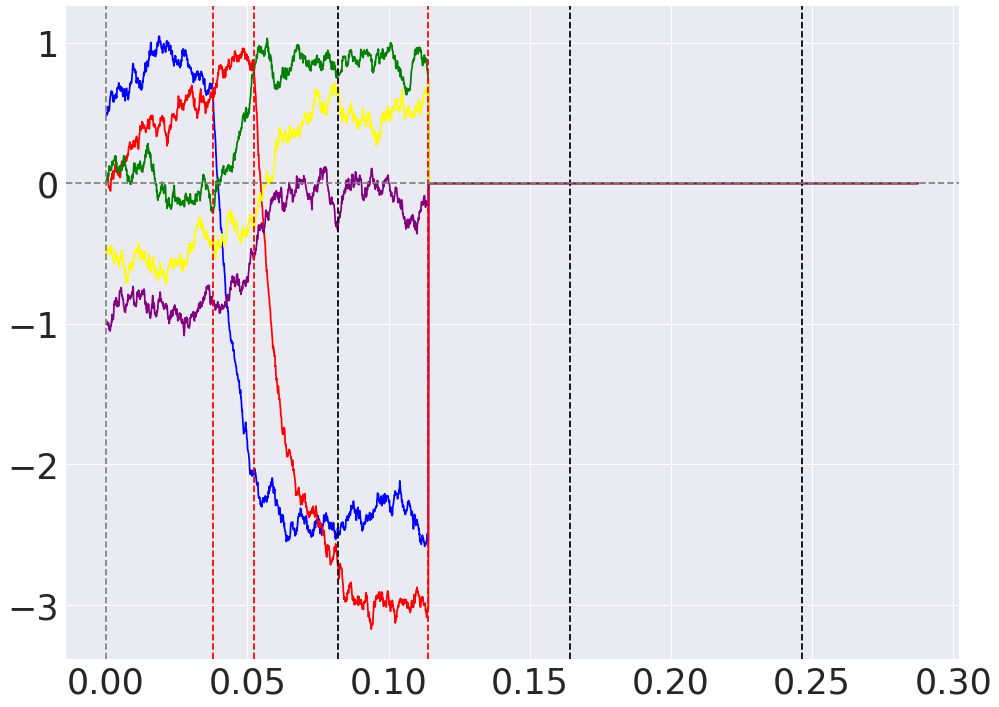

In [515]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

alpha = 1.0
ax.plot(time, s1.T, color='blue', alpha=alpha)
ax.plot(time, s2.T, color='red', alpha=alpha)
ax.plot(time, s3.T, color='green', alpha=alpha)
ax.plot(time, s4.T, color='yellow', alpha=alpha)
ax.plot(time, s5.T, color='purple', alpha=alpha)

ax.axvline(T_per, ls='--', color='black')
ax.axvline(2 * T_per , ls='--', color='black')
ax.axvline(3 * T_per , ls='--', color='black')

ax.axvline(T_win1, ls='--', color='red')
ax.axvline(T_win2 , ls='--', color='red')
ax.axvline(T_win3 , ls='--', color='red')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
# ax.set_xlim([0.020, 0.040])

In [544]:
def simulation_two_consecutive(sigma, w_self, alpha, w_back, tau_s, tau_a, g_a,  dt, T_total):

    sqrt_dt = np.sqrt(dt)
    time = np.arange(dt, T_total + dt, dt)
    nt = time.size

    s1 = np.zeros(nt)
    s1[0] = w_self - alpha
    noise1 = (sqrt_dt * sigma) * np.random.randn(nt)

    s2 = np.zeros(nt)
    s2[0] = w_self - 2 * alpha
    noise2 = (sqrt_dt * sigma) * np.random.randn(nt)

    s3 = np.zeros(nt)
    s3[0] = w_self - 2 * alpha
    noise3 = (sqrt_dt * sigma) * np.random.randn(nt)

    s4 = np.zeros(nt)
    s4[0] = w_self - 3 * alpha
    noise4 = (sqrt_dt * sigma) * np.random.randn(nt)
    
    s5 = np.zeros(nt)
    s5[0] = w_self - 4 * alpha
    noise5 = (sqrt_dt * sigma) * np.random.randn(nt)

    winner3 = np.nan
    T_win3 = np.nan
    
    current = w_self - g_a * (1 - np.exp(-time / tau_a))
    
    winner1 = 1
    index = 0
    while (winner1 == 1 and (index - 1) < nt):
        s1_ = s1[index] + (current[index] - s1[index]) * (dt / tau_s) +  noise1[index]
        s2_ = s2[index] + (w_self - alpha - s2[index]) * (dt / tau_s) +  noise2[index] 
        s3_ = s3[index] + (w_self - 2*alpha - s3[index]) * (dt / tau_s) +  noise3[index]
        s4_ = s4[index] + (w_self - 3*alpha - s4[index]) * (dt / tau_s) +  noise4[index]
        s5_ = s5[index] + (w_self - 4*alpha - s5[index]) * (dt / tau_s) +  noise5[index]
        
        s1[index + 1] = s1_
        s2[index + 1] = s2_
        s3[index + 1] = s3_
        s4[index + 1] = s4_
        s5[index + 1] = s5_

        index += 1

        if s1_ >= s1_ and s1_ >= s2_ and s1_ >= s3_ and s1_ >= s4_ and s1_ >= s5_:
            winner1 = 1
        if s2_ >= s1_ and s2_ >= s2_ and s2_ >= s3_ and s2_ >= s4_ and s2_ >= s5_:
            winner1 = 2
            T_win1 = index * dt
            break 
        if s3_ >= s1_ and s3_ >= s2_ and s3_ >= s3_ and s3_ >= s4_ and s3_ >= s5_:
            winner1 = 3
            T_win1 = index * dt
            break 
        if s4_ >= s1_ and s4_ >= s2_ and s4_ >= s3_ and s4_ >= s4_ and s4_ >= s5_:
            winner1 = 4
            T_win1 = index * dt
            break 
        if s5_ >= s1_ and s5_ >= s2_ and s5_ >= s3_ and s5_ >= s4_ and s5_ >= s5_:
            winner1 = 5
            T_win1 = index * dt
            break 
        
    winner2 = winner1
    factor = np.exp(T_win1 / tau_a)
    current2 = w_self - g_a * (1  - np.exp(-time / tau_a) * factor)
    if winner1 != 2:   # Not success on the first 
        winner2 = np.nan
        T_win2 = np.nan
    else:
        while(winner2 == 2 and (index - 1) < nt):
            s1_ = s1[index] + (w_back - s1[index]) * (dt / tau_s) +  noise1[index]
            s2_ = s2[index] + (current2[index] - s2[index]) * (dt / tau_s) +  noise2[index] 
            s3_ = s3[index] + (w_self - alpha - s3[index]) * (dt / tau_s) +  noise3[index]
            s4_ = s4[index] + (w_self - 2*alpha - s4[index]) * (dt / tau_s) +  noise4[index]
            s5_ = s5[index] + (w_self - 3*alpha - s5[index]) * (dt / tau_s) +  noise5[index]


            s1[index + 1] = s1_
            s2[index + 1] = s2_
            s3[index + 1] = s3_
            s4[index + 1] = s4_
            s5[index + 1] = s5_

            index += 1

            if s1_ >= s1_ and s1_ >= s2_ and s1_ >= s3_ and s1_ >= s4_ and s1_ >= s5_:
                winner2 = 1
                T_win2 = index * dt 
                break
            if s2_ >= s1_ and s2_ >= s2_ and s2_ >= s3_ and s2_ >= s4_ and s2_ >= s5_:
                winner2 = 2
            if s3_ >= s1_ and s3_ >= s2_ and s3_ >= s3_ and s3_ >= s4_ and s3_ >= s5_:
                winner2 = 3
                T_win2 = index * dt
                break 
            if s4_ >= s1_ and s4_ >= s2_ and s4_ >= s3_ and s4_ >= s4_ and s4_ >= s5_:
                winner2 = 4
                T_win2 = index * dt
                break 
            if s5_ >= s1_ and s5_ >= s2_ and s5_ >= s3_ and s5_ >= s4_ and s5_ >= s5_:
                winner2 = 5
                T_win2 = index * dt
                break 
                
    winner3 = winner2
    factor = np.exp(T_win2 / tau_a)
    current3 = w_self - g_a * (1  - np.exp(-time / tau_a) * factor)
    if winner2 != 3 and winner1 != 2:   # Not success on the first 
        winner3 = np.nan
        T_win3 = np.nan
    else:
        while(winner3==3 and (index - 1) < nt):
            s1_ = s1[index] + (w_back + alpha - s1[index]) * (dt / tau_s) +  noise1[index]
            s2_ = s2[index] + (w_back - s2[index]) * (dt / tau_s) +  noise2[index] 
            s3_ = s3[index] + (current3[index] - s3[index]) * (dt / tau_s) +  noise3[index]
            s4_ = s4[index] + (w_self - alpha - s4[index]) * (dt / tau_s) +  noise4[index]
            s5_ = s5[index] + (w_self - 2*alpha - s5[index]) * (dt / tau_s) +  noise5[index]


            s1[index + 1] = s1_
            s2[index + 1] = s2_
            s3[index + 1] = s3_
            s4[index + 1] = s4_
            s5[index + 1] = s5_

            index += 1


            if s1_ >= s1_ and s1_ >= s2_ and s1_ >= s3_ and s1_ >= s4_ and s1_ >= s5_:
                winner3 = 1
                T_win3 = index * dt
                break
            if s2_ >= s1_ and s2_ >= s2_ and s2_ >= s3_ and s2_ >= s4_ and s2_ >= s5_:
                winner3 = 2
                T_win3 = index * dt
                break
            if s3_ >= s1_ and s3_ >= s2_ and s3_ >= s3_ and s3_ >= s4_ and s3_ >= s5_:
                winner3 = 3
            if s4_ >= s1_ and s4_ >= s2_ and s4_ >= s3_ and s4_ >= s4_ and s4_ >= s5_:
                winner3 = 4
                T_win3 = index * dt
                break 
            if s5_ >= s1_ and s5_ >= s2_ and s5_ >= s3_ and s5_ >= s4_ and s5_ >= s5_:
                winner3 = 5
                T_win3 = index * dt
                break 
                
    return T_win1, T_win2, T_win3, winner1, winner2, winner3

In [539]:
%%time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
w_back = -3.0
alpha =  0.5

g_w = 1.0
g_a = 2.0

sigma = 0.0

w_diff = w_self - w_rest
dt = 0.0001
T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T_total = 2.5 * T_per

aux = simulation_two_consecutive(sigma, w_self, alpha, w_back, tau_s, tau_a, g_a,  dt, T_total)
T_win1, T_win2, T_win3, winner1, winner2, winner3 = aux
print(T_win1, T_win2, T_win3)
print(winner1, winner2, winner3)

0.0 0.319266014854
0.0821 0.319266014854 2
0.1642 0.319266014854 0.1642 3
0.0821 0.1642 0.24630000000000002
2 3 4
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 15.9 ms


In [551]:
%%time
tau_a = 0.250
tau_s = 0.010
w_self = 1.0
alpha = 0.5
w_back = -10.0
w_diff = alpha

g_a = 1.0
g_w = 1.0

num = 100
n_sim = 500
sigma_vector = np.linspace(0.1, 10, num=num)
winners1 = np.zeros((n_sim, num))
winners2 = np.zeros((n_sim, num))
winners3 = np.zeros((n_sim, num))
T_per_vector1 = np.zeros((n_sim, num))
T_per_vector2 = np.zeros((n_sim, num))
T_per_vector3 = np.zeros((n_sim, num))


T_per = calculate_T_persistence(tau_a, g_w, w_diff, g_a, tau_s, perfect=perfect)
T_total = 4.0 * T_per
dt = 0.0005
for sigma_index, sigma in enumerate(sigma_vector):
    for i in range(n_sim):
        aux = simulation_two_consecutive(sigma, w_self, alpha, w_back, tau_s, tau_a, g_a,  dt, T_total)
        T_win1, T_win2, T_win3, winner1, winner2, winner3 = aux
        winners1[i, sigma_index] = winner1
        T_per_vector1[i, sigma_index] = T_win1
        winners2[i, sigma_index] = winner2
        T_per_vector2[i, sigma_index] = T_win2
        winners3[i, sigma_index] = winner3
        T_per_vector3[i, sigma_index] = T_win3

CPU times: user 1min 12s, sys: 172 ms, total: 1min 13s
Wall time: 1min 13s


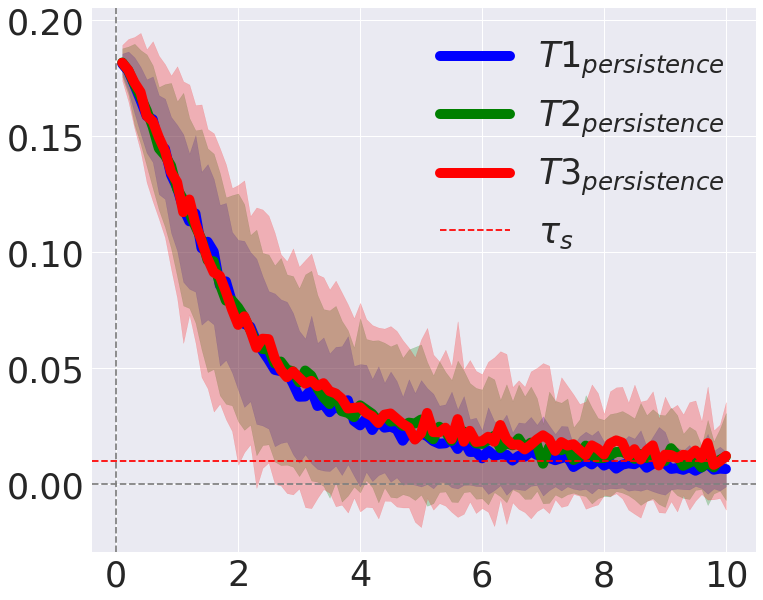

In [550]:
T_per_mean1 = np.mean(T_per_vector1, axis=0)
T_per_mean2 = np.nanmean(T_per_vector2, axis=0) - T_per_mean1
T_per_mean3 = np.nanmean(T_per_vector3, axis=0) - (T_per_mean1 + T_per_mean2)

std1 = np.std(T_per_vector1, axis=0)
std2 = np.nanstd(T_per_vector2, axis=0)
std3 = np.nanstd(T_per_vector3, axis=0)


lw = 10
alpha = 0.25

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sigma_vector, T_per_mean1, lw=lw, color='blue', label= r'$T1_{persistence}$')
ax.fill_between(sigma_vector, T_per_mean1 - std1, T_per_mean1 + std1,
                color='blue', alpha=alpha)

ax.plot(sigma_vector, T_per_mean2, lw=lw, color='green', label= r'$T2_{persistence}$')
ax.fill_between(sigma_vector, T_per_mean2 - std2, T_per_mean2 + std2,
                color='green', alpha=alpha)

ax.plot(sigma_vector, T_per_mean3, lw=lw, color='red', label= r'$T3_{persistence}$')
ax.fill_between(sigma_vector, T_per_mean3 - std3, T_per_mean3 + std3,
                color='red', alpha=alpha)

ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

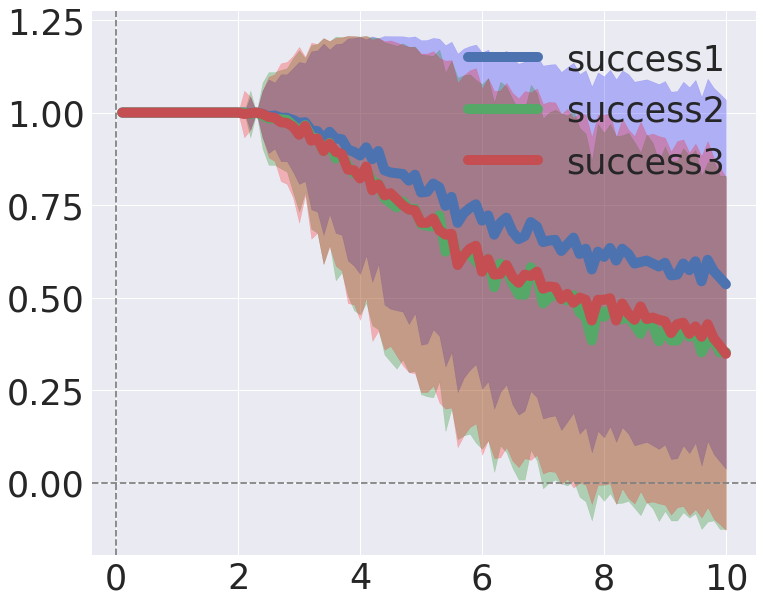

In [554]:
lw = 10
alpha = 0.25
success1 = np.mean(winners1 == 2, axis=0)
std_success1 = np.std(winners1 == 2, axis=0)

success2 = np.nanmean(winners2 == 3, axis=0)
std_success2 = np.nanstd(winners2 == 3, axis=0)

success3 = np.nanmean(winners3 == 4, axis=0)
std_success3 = np.nanstd(winners3 == 4, axis=0)


fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sigma_vector, success1, lw=lw, label='success1')
ax.fill_between(sigma_vector, success1 - std_success1, success1 + std_success1,
                color='blue', alpha=alpha)

ax.plot(sigma_vector, success2, lw=lw, label='success2')
ax.fill_between(sigma_vector, success2 - std_success2, success2 + std_success2,
                color='green', alpha=alpha)

ax.plot(sigma_vector, success3, lw=lw, label='success3')
ax.fill_between(sigma_vector, success3 - std_success3, success3 + std_success3,
                color='red', alpha=alpha)


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(sigma_vector, failure1, lw=lw, label='failure1')
ax.fill_between(sigma_vector, failure1 - std_failure1, failure1 + std_failure1,
                color='blue', alpha=alpha)

ax.plot(sigma_vector, failure2, lw=lw, label='failure2')
ax.fill_between(sigma_vector, failure2 - std_failure2, failure2 + std_failure2,
                color='green', alpha=alpha)


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.legend();

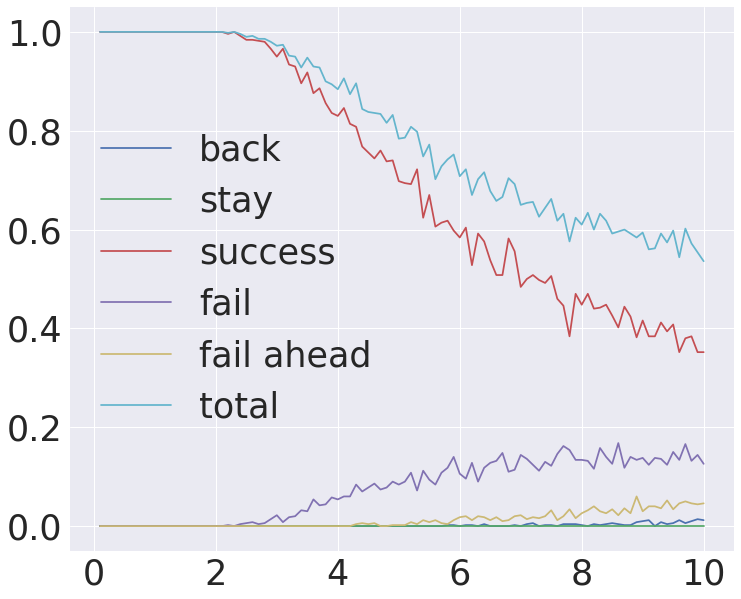

In [556]:
total = np.nanmean(winners2 == 4, axis=0) + np.nanmean(winners2 == 1, axis=0)  
total += np.nanmean(winners2 == 5, axis=0) + np.nanmean(winners2 == 3, axis=0) + np.nanmean(winners2==2, axis=0)

plt.plot(sigma_vector, np.nanmean(winners2 == 1, axis=0), label='back')
plt.plot(sigma_vector, np.nanmean(winners2 == 2, axis=0), label='stay')
plt.plot(sigma_vector, np.nanmean(winners2 == 3, axis=0), label='success')
plt.plot(sigma_vector, np.nanmean(winners2 == 4, axis=0), label='fail')
plt.plot(sigma_vector, np.nanmean(winners2 == 5, axis=0), label='fail ahead')
plt.plot(sigma_vector, total, label='total')


plt.legend()

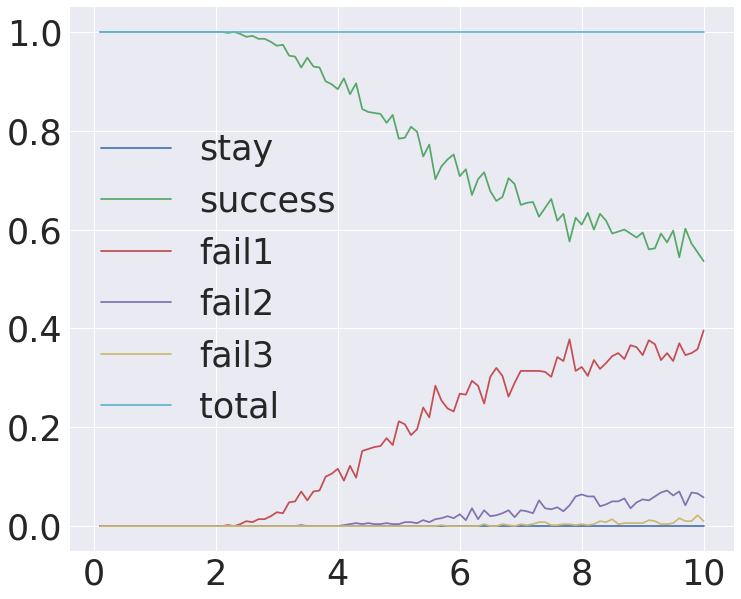

In [561]:
total = np.nanmean(winners1 == 4, axis=0) + np.nanmean(winners1 == 1, axis=0)  
total += np.nanmean(winners1 == 5, axis=0) + np.nanmean(winners1 == 3, axis=0) + np.nanmean(winners1==2, axis=0)

plt.plot(sigma_vector, np.nanmean(winners1 == 1, axis=0), label='stay')
plt.plot(sigma_vector, np.nanmean(winners1 == 2, axis=0), label='success')
plt.plot(sigma_vector, np.nanmean(winners1 == 3, axis=0), label='fail1')
plt.plot(sigma_vector, np.nanmean(winners1 == 4, axis=0), label='fail2')
plt.plot(sigma_vector, np.nanmean(winners1 == 5, axis=0), label='fail3')
plt.plot(sigma_vector, total, label='total')


plt.legend()

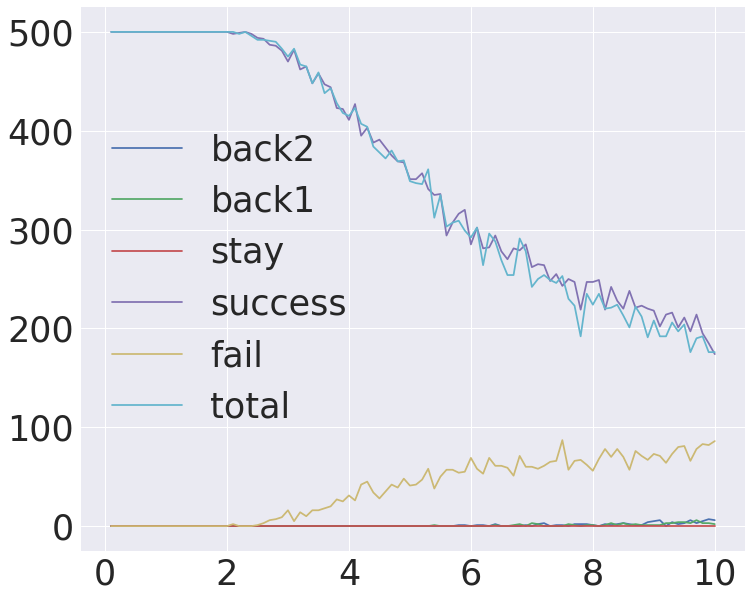

In [568]:
total = np.nanmean(winners3 == 4, axis=0) + np.nanmean(winners3 == 1, axis=0)  
total += np.nanmean(winners3 == 5, axis=0) + np.nanmean(winners3 == 3, axis=0) + np.nanmean(winners3==2, axis=0)
total = np.nansum(winners2 == 3, axis=0)

plt.plot(sigma_vector, np.nansum(winners3 == 1, axis=0), label='back2')
plt.plot(sigma_vector, np.nansum(winners3 == 2, axis=0), label='back1')
plt.plot(sigma_vector, np.nansum(winners3 == 3, axis=0), label='stay')
plt.plot(sigma_vector, np.nansum(winners3 == 4, axis=0), label='success')
plt.plot(sigma_vector, np.nansum(winners3 == 5, axis=0), label='fail')
plt.plot(sigma_vector, total, label='total')


plt.legend()

In [570]:
n_survival = np.sum(winners1 == 2, axis=0)
n_survival

array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 500, 499, 500, 498, 495, 496,
       493, 493, 490, 486, 487, 476, 475, 464, 474, 465, 464, 450, 447,
       442, 453, 437, 448, 422, 419, 418, 417, 408, 416, 392, 393, 404,
       399, 374, 386, 351, 364, 371, 376, 354, 361, 335, 351, 358, 339,
       329, 333, 352, 346, 325, 327, 328, 313, 322, 331, 309, 316, 288,
       312, 305, 317, 300, 316, 309, 296, 298, 300, 296, 292, 297, 280,
       281, 296, 287, 299, 272, 301, 286, 277, 268])

In [569]:
np.nansum(winners3 == 4, axis=0)


array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 500, 500, 498, 499, 500, 498, 494, 493,
       487, 486, 481, 470, 482, 462, 465, 448, 458, 447, 444, 423, 422,
       411, 427, 395, 403, 388, 391, 383, 375, 369, 368, 351, 351, 357,
       341, 335, 336, 294, 307, 316, 320, 285, 302, 281, 282, 294, 278,
       270, 281, 279, 285, 262, 265, 264, 248, 255, 243, 250, 247, 219,
       247, 247, 249, 219, 242, 228, 220, 238, 221, 223, 220, 218, 202,
       214, 216, 201, 211, 197, 214, 195, 185, 174])

In [567]:
np.nansum(winners3 == 4, axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [577]:
np.unique(winners3).shape

(9960,)

In [575]:
winners3.shape

(500, 100)